In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math
import numpy as np
from numba import cuda, jit, float64, prange
from numba.cuda import jit 
import time
import pandas as pd

cuda.detect()

Found 1 CUDA devices
id 0            b'Tesla K80'                              [SUPPORTED]
                      compute capability: 3.7
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

In [3]:
N0 = np.random.randint(100, 2000)
A0 = np.random.randn(N0, N0)
B0 = np.random.randn(N0, N0)
C0 = np.zeros((N0, N0))

In [4]:
N1 = np.random.randint(100, 2000)
A1 = np.random.randn(N1, N1)
B1 = np.random.randn(N1, N1)
C1 = np.zeros((N1, N1))

In [5]:
N2 = np.random.randint(100, 2000)
A2 = np.random.randn(N2, N2)
B2 = np.random.randn(N2, N2)
C2 = np.zeros((N2, N2))

In [6]:
def matmul_CPU(A, B, C):
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      sum = 0
      for k in range(A.shape[1]):
        sum += A[i, k] * B[k, j]
      C[i, j] = sum
      return C

host_1 = C0

start = time.time()
matmul_CPU(A0, B0, C0)
print(' -----------------------------')
print('| Matmul on CPU: {:.6f}'.format(time.time() - start), 'sec.|')
end0 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on CPU: 0.001494 sec.|
 -----------------------------


In [7]:
start = time.time()
matmul_CPU(A1, B1, C1)
print(' -----------------------------')
print('| Matmul on CPU: {:.6f}'.format(time.time() - start), 'sec.|')
end1 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on CPU: 0.001051 sec.|
 -----------------------------


In [8]:
start = time.time()
matmul_CPU(A2, B2, C2)
print(' -----------------------------')
print('| Matmul on CPU: {:.6f}'.format(time.time() - start), 'sec.|')
end2 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on CPU: 0.001531 sec.|
 -----------------------------


In [9]:
@cuda.jit
def matmul_GPU(A, B, C):
  i, j = cuda.grid(2)
  if i < C.shape[0] and j < C.shape[1]:
    sum = 0
    for k in range(A.shape[1]):
      sum += A[i, k] * B[k, j]
    C[i, j] = sum

def host_naive(A, B, C):
  d_A = cuda.to_device(A)
  d_B = cuda.to_device(B)
  d_C = cuda.device_array(C.shape, np.float64)

  threadsperblock = (16, 16)
  blockspergrid_x = math.ceil(A.shape[0]/threadsperblock[0])
  blockspergrid_y = math.ceil(B.shape[1]/threadsperblock[1])
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  matmul_GPU[blockspergrid, threadsperblock](d_A, d_B, d_C)
  return d_C.copy_to_host()

host_2 = C0
start = time.time()
host_naive(A0, B0, C0)
print(' -----------------------------')
print('| Matmul on GPU: {:.6f}'.format(time.time() - start), 'sec.|')
end3 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on GPU: 1.112264 sec.|
 -----------------------------


In [10]:
start = time.time()
host_naive(A1, B1, C1)
print(' -----------------------------')
print('| Matmul on GPU: {:.6f}'.format(time.time() - start), 'sec.|')
end4 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on GPU: 0.129874 sec.|
 -----------------------------


In [11]:
start = time.time()
host_naive(A2, B2, C2)
print(' -----------------------------')
print('| Matmul on GPU: {:.6f}'.format(time.time() - start), 'sec.|')
end5 = time.time() - start
print(' -----------------------------')

 -----------------------------
| Matmul on GPU: 0.064022 sec.|
 -----------------------------


In [12]:
print('Проверка корректности перемножения матриц') 
print('Если матрицы равны, то будет True:', np.allclose(host_1, host_2))

Проверка корректности перемножения матриц
Если матрицы равны, то будет True: True


In [13]:
timing_df = pd.DataFrame({'Name':['CPU', 'GPU', 'CPU', 'GPU', 'CPU', 'GPU'], 'Time(s)':[end0, end3, end1, end4, end2, end5], 'Matrix size':[N0, N0, N1, N1, N2, N2]})
timing_df

,Name,Time(s),Matrix size
0,CPU,0.001671,1602
1,GPU,1.112504,1602
2,CPU,0.001460,990
3,GPU,0.130031,990
4,CPU,0.001780,777
5,GPU,0.064163,777


In [14]:
acc = pd.DataFrame({'Acceleration':[end0/end3, end1/end4, end2/end5]})
acc

,Acceleration
0,0.001502
1,0.011230
2,0.027735


In [15]:
import matplotlib.pyplot as plt

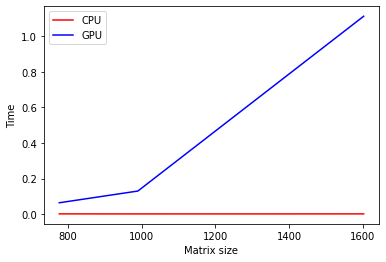

In [16]:
plt.plot([N0, N1, N2], [end0, end1, end2], color = 'red' , label = 'CPU')
plt.plot([N0, N1, N2], [end3, end4, end5], color = 'blue', label = 'GPU')
plt.xlabel('Matrix size')
plt.ylabel('Time')
plt.legend()